## Testes Baseados em Estatística Descritiva
Nas próximas aulas veremos diferentes modelos de previsão como ARMA, ARIMA, ARIMA sazonal entre outros. Cada modelo aborda um tipo diferente de série temporal. Por esta razão, para selecionar um modelo apropriado precisamos entender melhor os dados. A estatística descritiva serve exatamente para isso.

Nesta aula aprenderemos como determinar se uma série temporal é *estacionária*, se é *independente* e se duas séries demonstram *correlação* e/ou *causalidade*.

Vamos começar fazendo os imports e carregando os datasets que serão utilizados.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import mse, rmse, meanabs
%matplotlib inline

# Ignorar warnings 
import warnings
warnings.filterwarnings("ignore")

# Load a seasonal dataset
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

### Teste de Estacionariedade
Uma série temporal é <em>estacionária</em> se a média e a variância são fixas entre quaisquer dois pontos equidistantes. Ou seja, não importa onde você faça suas observações, os resultados deverão ser os mesmos. Uma série temporal que mostra sazonalidade <em>não</em> é estacionária.

Um teste de estacionariedade geralmente envolve um teste de hipótese de <a href='https://en.wikipedia.org/wiki/Unit_root_test'>raiz unitária</a>, onde a hipótese nula $H_0$ é que a série é <em >não estacionária</em> e contém uma raiz unitária. A hipótese alternativa $H_1$ suporta a estacionariedade. O <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>Dikey-Fuller aumentado</a> e o <a href='https://en.wikipedia.org/wiki/KPSS_test Os testes '>Kwiatkowski-Phillips-Schmidt-Shin</a> são testes de estacionariedade.

### Teste Dikey-Fuller Aumentado
Para determinar se uma série é estacionária, podemos usar o <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>teste Dickey-Fuller aumentado</a>. Neste teste, a hipótese nula afirma que $\phi = 1$ (isso também é chamado de teste de unidade). O teste retorna diversas estatísticas que veremos em instantes. Nosso foco está no *p value*. Um *p value* pequeno ($p<0,05$) indica forte evidência contra a hipótese nula.

Para demonstrar, usaremos um conjunto de dados que sabemos que <em>não</em> é estacionário (airline passengers). Primeiro, vamos representar graficamente os dados junto com uma média móvel e desvio padrão de 12 meses:

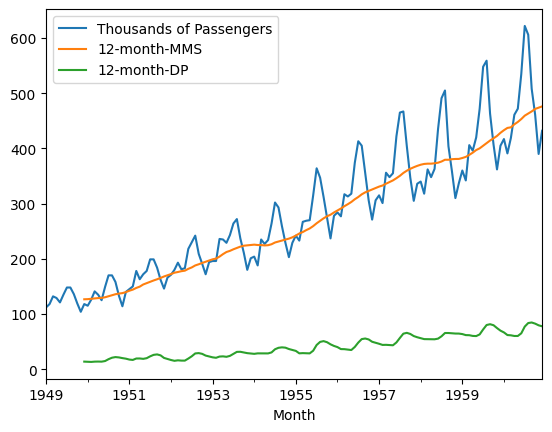

In [4]:
df1['12-month-MMS'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-DP'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-MMS','12-month-DP']].plot();

Observamos que este conjunto de dados não só é sazonal com uma clara tendência ascendente, como também o desvio padrão aumenta ao longo do tempo.

Vamos fazer o teste de Dickey-Fuller aumentado e observar os resultados.

In [5]:
print('Teste Dickey-Fuller aumentado para o dataset airline passengers')
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')
dftest

Teste Dickey-Fuller aumentado para o dataset airline passengers


(0.8153688792060539,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Vamos acrescentar legendas para ficar mais fácil de interpretar os resultados do teste.

In [6]:
print('Teste Dickey-Fuller aumentado para o dataset airline passengers')

dfout = pd.Series(dftest[0:4],index=['ADF estatística de teste','p-value','# lags usedos','# observações'])

for key,val in dftest[4].items():
    dfout[f'Valor crítico ({key})']=val
print(dfout)

Teste Dickey-Fuller aumentado para o dataset airline passengers
ADF estatística de teste      0.815369
p-value                       0.991880
# lags usedos                13.000000
# observações               130.000000
Valor crítico (1%)           -3.481682
Valor crítico (5%)           -2.884042
Valor crítico (10%)          -2.578770
dtype: float64


Aqui temos um p-value muito alto de 0,99, que fornece evidências fracas contra a hipótese nula e, portanto, <em>não rejeitamos</em> a hipótese nula e decidimos que nosso conjunto de dados não é estacionário. \
Nota: em estatística, ao não “aceitarmos” uma hipótese nula, nada é verdadeiramente provado, apenas falhamos em rejeitá-la. \
Agora vamos aplicar o teste ADF a dados estacionários com o conjunto de dados Daily Total Female Births.

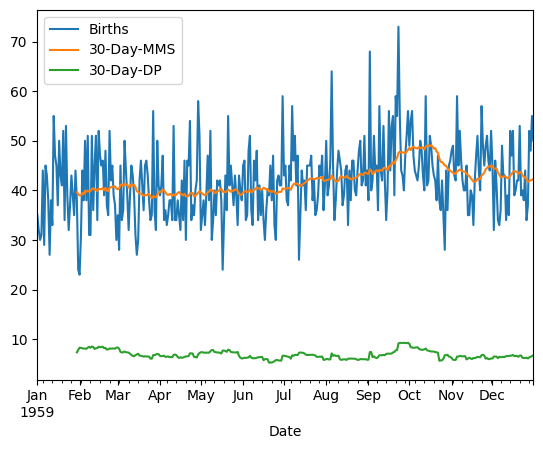

In [7]:
df2['30-Day-MMS'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-DP'] = df2['Births'].rolling(window=30).std()

df2[['Births','30-Day-MMS','30-Day-DP']].plot();

In [8]:
print('Teste Dickey-Fuller aumentado para o dataset Daily Female Births')
dftest = adfuller(df2['Births'],autolag='AIC')
dfout = pd.Series(dftest[0:4],index=['Estatística de teste ADF','p-value','# lags usados','# observações'])

for key,val in dftest[4].items():
    dfout[f'Valor crítico ({key})']=val
print(dfout)

Teste Dickey-Fuller aumentado para o dataset Daily Female Births
Estatística de teste ADF     -4.808291
p-value                       0.000052
# lags usados                 6.000000
# observações               358.000000
Valor crítico (1%)           -3.448749
Valor crítico (5%)           -2.869647
Valor crítico (10%)          -2.571089
dtype: float64


Neste caso, o p-value é muito baixo: 0,000052; o que nos leva a rejeitar a hipótese nula. Este conjunto de dados parece não ter raiz unitária e é estacionário.

### Função para facilitar a tomada de decisão baseada no teste ADF
Como o usaremos com frequência nas próximas previsões, vamos definir uma função que possamos copiar em notebooks futuros para executar o teste Dickey-Fuller aumentado. Lembre-se que ainda teremos que importar <tt>adfuller</tt> no topo do nosso notebook.

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Param: série temporal e um título opcional, retorna um relatório ADF

    """
    print(f'Teste Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['Estatística de teste ADF','p-value','# lags usados','# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'Valor crítico ({key})']=val
        
    print(out.to_string())          # .to_string() remove a linha "dtype: float64"
    
    if result[1] <= 0.05:
        print("Evidência forte contra a hipótese nula.")
        print("Rejeitar a hipótese nula.")
        print("Dados não tem raiz unitária. Série estacionária.")
    else:
        print("Evidência fraca contra a hipótese nula.")
        print("Falha em rejeitar a hipótese nula.")
        print("Dados tem uma raiz unitária. Série não estacionária.")

In [13]:
adf_test(df1['Thousands of Passengers'], 'Airline Passengers')
print()
adf_test(df2['Births'], 'Daily Female Births')

Teste Dickey-Fuller Aumentado: Airline Passengers
Estatística de teste ADF      0.815369
p-value                       0.991880
# lags usados                13.000000
# observações               130.000000
Valor crítico (1%)           -3.481682
Valor crítico (5%)           -2.884042
Valor crítico (10%)          -2.578770
Evidência fraca contra a hipótese nula.
Falha em rejeitar a hipótese nula.
Dados tem uma raiz unitária. Série não estacionária.

Teste Dickey-Fuller Aumentado: Daily Female Births
Estatística de teste ADF     -4.808291
p-value                       0.000052
# lags usados                 6.000000
# observações               358.000000
Valor crítico (1%)           -3.448749
Valor crítico (5%)           -2.869647
Valor crítico (10%)          -2.571089
Evidência forte contra a hipótese nula.
Rejeitar a hipótese nula.
Dados não tem raiz unitária. Série estacionária.


### Teste de Causalidade de Granger
O <a href='https://en.wikipedia.org/wiki/Granger_causality'>Teste de Causalidade de Granger</a> é um teste de hipótese para determinar se uma série temporal é útil na previsão de outra. Embora seja bastante fácil medir correlações entre séries - quando uma sobe, a outra sobe e vice-versa - outra coisa é observar mudanças em uma série correlacionadas com mudanças em outra após um período de tempo consistente. Isto pode indicar a presença de causalidade, de que mudanças na primeira série influenciaram o comportamento da segunda. Contudo, também pode acontecer que ambas as séries sejam afetadas por algum terceiro fator, apenas a taxas diferentes. Ainda assim, pode ser útil se as mudanças numa série puderem prever mudanças futuras noutra, quer haja causalidade ou não. Neste caso, dizemos que uma série “causa Granger” outra.

No caso de duas séries, $y$ e $x$, a hipótese nula é que valores defasados ​​de $x$ <em>não</em> explicam variações em $y$.<br>
Em outras palavras, assume que $x_t$ não causa Granger $y_t$.

Neste exemplo, usaremos o arquivo samples.csv, onde as colunas 'a' e 'd' são conjuntos de dados estacionários.

In [14]:
df3 = pd.read_csv('samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


<Axes: >

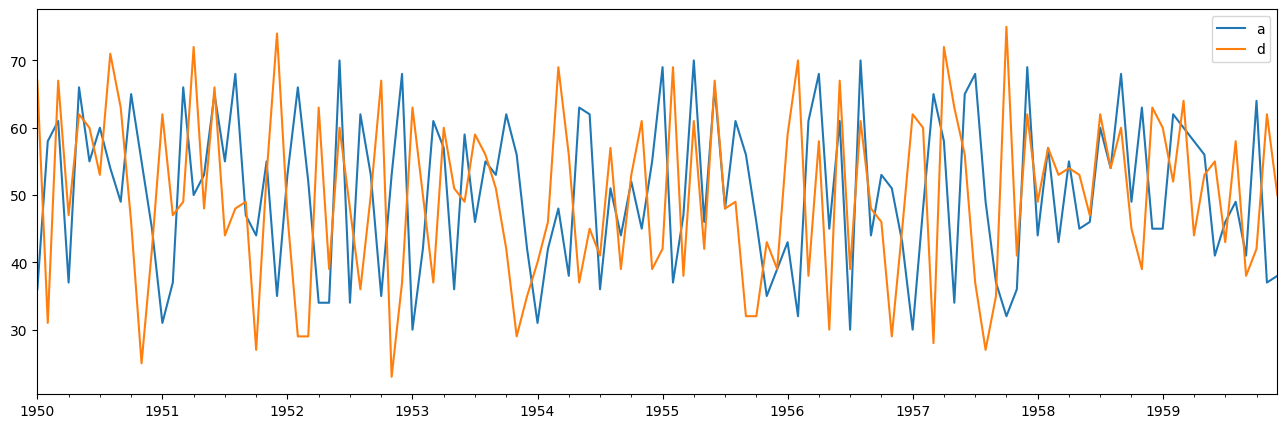

In [15]:
df3[['a' , 'd']].plot(figsize=(16,5))

É difícil observar a partir da figura, mas <tt>df['d']</tt> prevê quase perfeitamente o comportamento de <tt>df['a']</tt>.<br>
Para ver isso mais claramente, avançaremos <tt>df['d']</tt> dois períodos.

<Axes: >

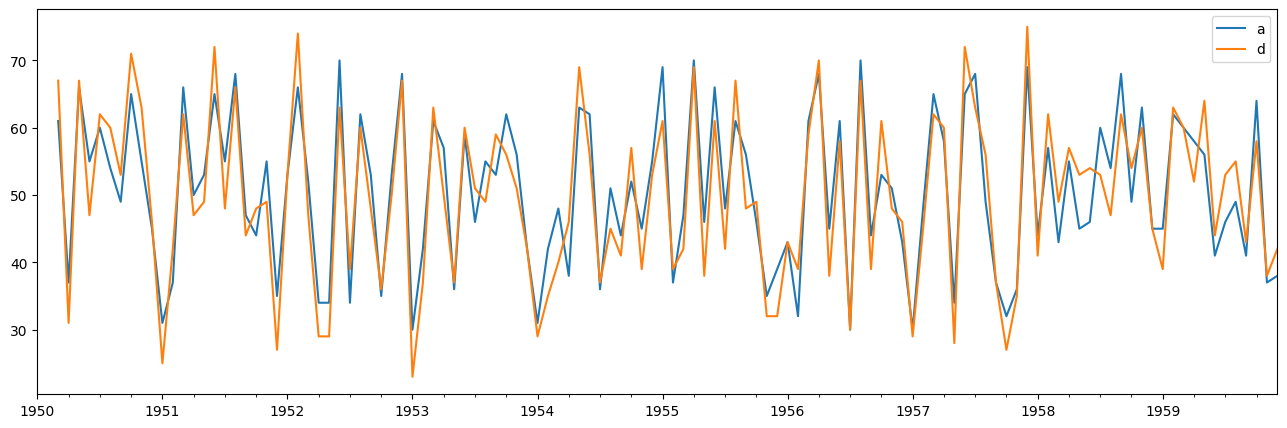

In [17]:
df3['a'].iloc[2:].plot(figsize=(16,5) , legend=True)
df3['d'].shift(2).plot(figsize=(16,5) , legend=True)

Vamos agora executar o teste. \
A função recebe um array 2D [y,x] e um número máximo de defasagens (lags) para testar em x. Aqui nosso y é a coluna 'a' e x é a coluna 'd'. Usaremos maxlags = 3.

In [18]:
grangercausalitytests(df3[['a' , 'd']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


{1: ({'ssr_ftest': (1.7051251051681098, 0.1942027811635688, 116.0, 1),
   'ssr_chi2test': (1.7492231682328023, 0.18597442074424264, 1),
   'lrtest': (1.7364915553187075, 0.18758398456227507, 1),
   'params_ftest': (1.7051251051681222, 0.1942027811635669, 116.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (286.0339426255609, 6.025362015680932e-45, 113.0, 2),
   'ssr_chi2test': (597.3806235365696, 1.9074176679054406e-130, 2),
   'lrtest': (212.65135382912013, 6.658022084670888e-47, 2),
   'params_ftest': (286.0339426255569, 6.025362015684885e-45, 113.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (188.74462328616235, 3.2288482941467997e-43, 110.0, 3),
   'ssr_chi2test': (602.2669343040271, 3.2505045874684837e-130, 3),
   'lrtest': (212.4788575746154, 8.480665715595584e-46, 3),
   'params_ftest': (188.744623286161, 3.228848294147858e-43, 110.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

Valores extremamente baixos de p, como vemos no lag 2, apontam a causalidade. \
Em seguida, vamos comparar dois conjuntos de dados que não são nada semelhantes, 'b' e 'd'.

In [19]:
grangercausalitytests(df3[['b' , 'd']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


{1: ({'ssr_ftest': (1.5225271098609905, 0.219731606038821, 116.0, 1),
   'ssr_chi2test': (1.561902810978085, 0.2113868295267777, 1),
   'lrtest': (1.5517414581132698, 0.21287853854121006, 1),
   'params_ftest': (1.5225271098609818, 0.219731606038821, 116.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4350444134914053, 0.6483153418342305, 113.0, 2),
   'ssr_chi2test': (0.908588332601519, 0.634895940782984, 2),
   'lrtest': (0.9051081656513134, 0.636001674473408, 2),
   'params_ftest': (0.43504441349139167, 0.6483153418342387, 113.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5333223212193094, 0.6603817798496392, 110.0, 3),
   'ssr_chi2test': (1.7017830431634327, 0.6365374570974305, 3),
   'lrtest': (1.6895254112311022, 0.6392650421085297, 3),
   'params_ftest': (0.5333223212193042, 0.6603817798496421, 110.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 

Aqui não temos valores de p tendendo a zero, o que mostra que não há causalidade nessas duas séries temporais.

### Avaliação de Precisão
Dois cálculos relacionados à regressão linear são <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>erro quadrático médio</strong></a> (MSE) e <a href=' https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>raiz do erro quadrático médio</strong></a> (RMSE).

A fórmula do erro quadrático médio é <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>
A vantagem do RMSE é que ele é expresso nas mesmas unidades que os dados. <br><br>

Um método semelhante ao RMSE é o <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>erro absoluto médio</strong></a> (MAE), que é a média das magnitudes do erro, dadas como<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

Um método de previsão que minimize o MAE levará a previsões da mediana, enquanto a minimização do RMSE levará a previsões da média.

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['teste','previsão'])
df.plot(figsize=(12,4));

In [ ]:
MSE = mse(df['teste'],df['previsão'])
RMSE = rmse(df['teste'],df['previsão'])
MAE = meanabs(df['teste'],df['previsão'])

print(f'Modelo  MSE: {MSE:.3f}')
print(f'Modelo RMSE: {RMSE:.3f}')
print(f'Modelo  MAE: {MAE:.3f}')

Modelo  MSE: 17.020
Modelo RMSE: 4.126
Modelo  MAE: 3.540


### AIC / BIC
Testes mais sofisticados incluem o <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>critério de informação Akaike</strong></a> (AIC) e o <a href='https ://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Critério de informação bayesiano</strong></a> (BIC).

A AIC avalia uma coleção de modelos e estima a qualidade de cada modelo em relação aos demais. Penalidades são fornecidas para o número de parâmetros usados ​​em um esforço para impedir o sobreajuste. Quanto mais baixos o AIC e o BIC, melhor deverá ser o modelo na previsão.

Estas funções estão disponíveis como:

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

mas raramente os computamos sozinhos, pois eles estão integrados em muitas das ferramentas de modelos estatísticos que usamos.

### Expondo sazonalidade utilizando gráficos mensais e quadrimestrais
Statsmodels possui duas funções de plotagem que agrupam os dados por mês e por trimestre. Observe que se os dados aparecerem como meses, você deverá empregar <em>reamostragem</em> com uma função agregada antes de executar um gráfico trimestral. Esses gráficos retornam um objeto <tt>matplotlib.Figure</tt>.
<h3>Métodos de plotagem relacionados:</h3>
<tt><forte>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html'>tsaplots.month_plot</a></strong><font color=black>(x) </font>&nbsp;&nbsp;&nbsp;&nbsp;Gráfico sazonal de dados mensais<br>
<forte>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.quarter_plot.html'>tsaplots.quarter_plot</a></strong><font color=black>(x) </font>&nbsp;&nbsp;Gráfico sazonal de dados trimestrais</tt>

In [20]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Vamos comparar com nosso conjunto de dados <tt>macrodata.csv</tt> não sazonal:


### Exercício 01
Considere a série temporal contida em "exercicio01.xlsx". Plote o gráfico correspondente e informe se a série é ou não estacionária.

/tmp/ipykernel_13468/1916424438.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfex1 = pd.read_excel('exercicio1.xlsx',index_col='Time',parse_dates=True)


Teste Dickey-Fuller Aumentado: exercicio1.xlsx
Estatística de teste ADF     -22.184930
p-value                        0.000000
# lags usados                  0.000000
# observações               9999.000000
Valor crítico (1%)            -3.431004
Valor crítico (5%)            -2.861829
Valor crítico (10%)           -2.566924
Evidência forte contra a hipótese nula.
Rejeitar a hipótese nula.
Dados não tem raiz unitária. Série estacionária.


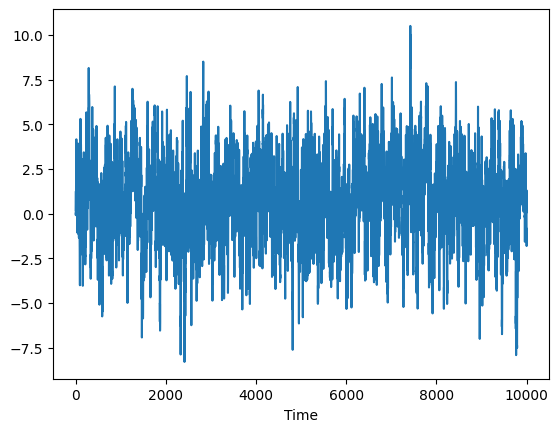

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import mse, rmse, meanabs
%matplotlib inline

dfex1 = pd.read_excel('exercicio1.xlsx',index_col='Time',parse_dates=True)
dfex1.head()

dfex1['Value'].plot()

adf_test(dfex1['Value'] , 'exercicio1.xlsx')


### Exercício 02
Considere a série temporal contida em "exercicio02.xlsx". Plote o gráfico correspondente e informe se a série é ou não estacionária.

Teste Dickey-Fuller Aumentado: exercicio1.xlsx
Estatística de teste ADF    -1.743415
p-value                      0.408894
# lags usados                0.000000
# observações               25.000000
Valor crítico (1%)          -3.723863
Valor crítico (5%)          -2.986489
Valor crítico (10%)         -2.632800
Evidência fraca contra a hipótese nula.
Falha em rejeitar a hipótese nula.
Dados tem uma raiz unitária. Série não estacionária.


/tmp/ipykernel_13468/1180175866.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfex2 = pd.read_excel('exercicio2.xlsx',index_col='Time',parse_dates=True)


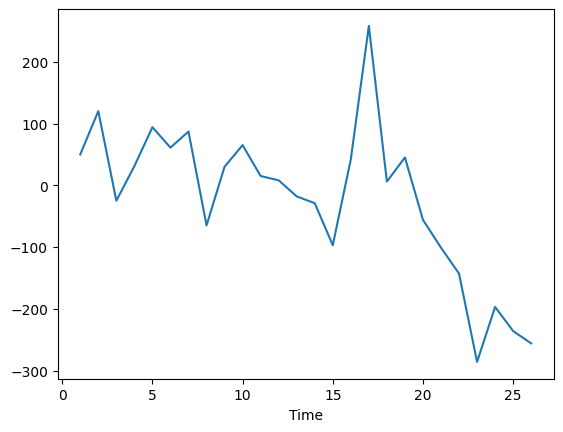

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import mse, rmse, meanabs
%matplotlib inline

dfex2 = pd.read_excel('exercicio2.xlsx',index_col='Time',parse_dates=True)
dfex2.head()

dfex2['Value'].plot()

adf_test(dfex2['Value'] , 'exercicio1.xlsx')

### Exercício 03
Neste exercício você deve utilizar o dataset "chicken_egg", que mostra a quantidade de galinhas e ovos produzidos entre os anos de 1930 e 1983 numa dada localidade.

A) Verifique se o número de ovos pode ser usado para prever o número de galinhas no futuro. (Ovos Granger Cause Galinhas).

B) Verifique se o número de galinhas pode ser usado para prever o número de ovos no futuro. (Galinhas Granger Cause Ovos).

In [25]:
#define URL where dataset is located
url = "https://raw.githubusercontent.com/Statology/Miscellaneous/main/chicken_egg.txt"

#read in dataset as pandas DataFrame
df_ex3 = pd.read_csv(url, sep="  ", index_col=0, parse_dates=True)

df_ex3.head()

/tmp/ipykernel_13468/1991830818.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_ex3 = pd.read_csv(url, sep="  ", index_col=0, parse_dates=True)


,chicken,egg
year,,
1930-01-01,468491,3581
1931-01-01,449743,3532
1932-01-01,436815,3327
1933-01-01,444523,3255
1934-01-01,433937,3156


Parte A \
H0: a quantidade de ovos NÃO está relacionada com a quantidade de galinhas no futuro \
H1: a quantidade de ovos está relacionada com a quantidade de galinhas no futuro

Em outras palavras: a quantidade atual de ovos pode ser usada para prever a quantidade futura de galinhas?

<Axes: xlabel='year'>

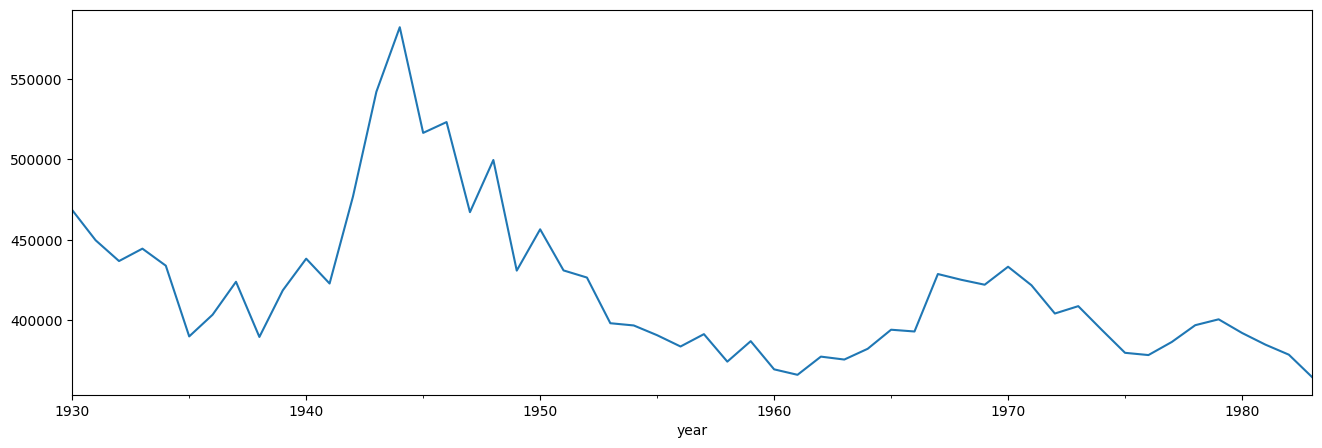

In [26]:
df_ex3['chicken'].plot(figsize=(16,5))

<Axes: xlabel='year'>

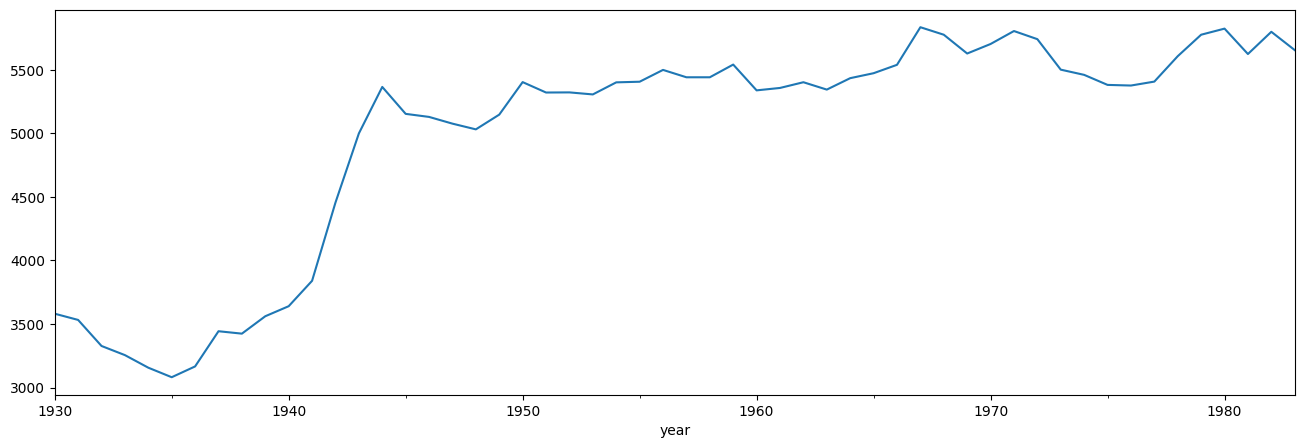

In [27]:
df_ex3['egg'].plot(figsize=(16,5))

In [29]:
grangercausalitytests(df_ex3[['chicken' , 'egg']] , maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2071  , p=0.2772  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=1.2795  , p=0.2580  , df=1
likelihood ratio test: chi2=1.2643  , p=0.2608  , df=1
parameter F test:         F=1.2071  , p=0.2772  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.8175  , p=0.0006  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=19.5110 , p=0.0001  , df=2
likelihood ratio test: chi2=16.5676 , p=0.0003  , df=2
parameter F test:         F=8.8175  , p=0.0006  , df_denom=47, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4050  , p=0.0030  , df_denom=44, df_num=3
ssr based chi2 test:   chi2=18.7946 , p=0.0003  , df=3
likelihood ratio test: chi2=16.0003 , p=0.0011  , df=3
parameter F test:         F=5.4050  , p=0.0030  , df_denom=44, df_num=3


{1: ({'ssr_ftest': (1.2071001073095102, 0.27716961823263575, 50.0, 1),
   'ssr_chi2test': (1.279526113748081, 0.25798716500988705, 1),
   'lrtest': (1.2643251216145472, 0.26083398909735267, 1),
   'params_ftest': (1.2071001073095364, 0.2771696182326321, 50.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (8.817472803317774, 0.00056016510504355, 47.0, 2),
   'ssr_chi2test': (19.511003649894647, 5.797481737181135e-05, 2),
   'lrtest': (16.567596056902858, 0.0002525760848622297, 2),
   'params_ftest': (8.817472803316516, 0.0005601651050440585, 47.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.404984372335098, 0.002966397445576194, 44.0, 3),
   'ssr_chi2test': (18.794604749256134, 0.0003014773550056756, 3),
   'lrtest': (16.000284988230305, 0.0011338317398181842, 3),
   'params_ftest': (5.404984372328257, 0.0029663974455972474, 44.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          

Parte B \
H0: a quantidade de galinhas NÃO está relacionada com a quantidade de ovos no futuro \
H1: a quantidade de galinhas está relacionada com a quantidade de ovos no futuro

Em outras palavras: a quantidade atual de galinhas pode ser usada para prever a quantidade futura de ovos?

In [30]:
grangercausalitytests(df_ex3[['egg' , 'chicken']] , maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0470  , p=0.8292  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=0.0499  , p=0.8233  , df=1
likelihood ratio test: chi2=0.0498  , p=0.8234  , df=1
parameter F test:         F=0.0470  , p=0.8292  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8800  , p=0.4215  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=1.9472  , p=0.3777  , df=2
likelihood ratio test: chi2=1.9116  , p=0.3845  , df=2
parameter F test:         F=0.8800  , p=0.4215  , df_denom=47, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5916  , p=0.6238  , df_denom=44, df_num=3
ssr based chi2 test:   chi2=2.0572  , p=0.5606  , df=3
likelihood ratio test: chi2=2.0168  , p=0.5689  , df=3
parameter F test:         F=0.5916  , p=0.6238  , df_denom=44, df_num=3


{1: ({'ssr_ftest': (0.04703185649930448, 0.8291934626130788, 50.0, 1),
   'ssr_chi2test': (0.04985376788926275, 0.8233179240739011, 1),
   'lrtest': (0.04983033542987414, 0.8233587660665145, 1),
   'params_ftest': (0.04703185649933022, 0.8291934626130291, 50.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.87998444711592, 0.42151137004186323, 47.0, 2),
   'ssr_chi2test': (1.9471996276607593, 0.3777208629993579, 2),
   'lrtest': (1.9116273782647113, 0.3844991544485495, 2),
   'params_ftest': (0.8799844471154553, 0.42151137004205275, 47.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5916153294547226, 0.6237862003923859, 44.0, 3),
   'ssr_chi2test': (2.0572078501493767, 0.5606182956436738, 3),
   'lrtest': (2.0167996971327966, 0.5689271966977385, 3),
   'params_ftest': (0.5916153294545388, 0.6237862003925032, 44.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

Se p não proximo de zero, aceita a hipotese nula
caso contrário aceita a hipotese alternativa

nesse caso, a quantidade de galinhas não está relacionado a quantidade de ovos